In [58]:
import torch
#Use this space for manually computing the scaled dot product attention

In [59]:
#This is how you'll do diagrams for tensors from here on out
import pandas as pd
#pd.DataFrame(input)

def printTensor(tensor):
    df = pd.DataFrame(tensor)
    print(df)

In [63]:
import matplotlib.pyplot as plt
import numpy as np

def plot_tensor(tensor):
    with torch.no_grad():
        tensor = tensor.squeeze(0)
        x = tensor[:, 0].detach().numpy()
        y = tensor[:, 1].detach().numpy()
        plt.scatter(x, y)
        plt.show()

In [64]:
input = torch.tensor([[-1.5898,1.5792,0.8666,1.0245],[2.2796,0.9813,1.4023,-0.6616],[0.1588,0.4028,-1.7044,-1.8284],[0.4366,-1.0197,-0.4217, 1.4877],[-0.8311,-0.1762,-1.8709,2.2313]], dtype=torch.float32)
input.shape
#Paper example input from embedding layers

torch.Size([5, 4])

WQ matrix:


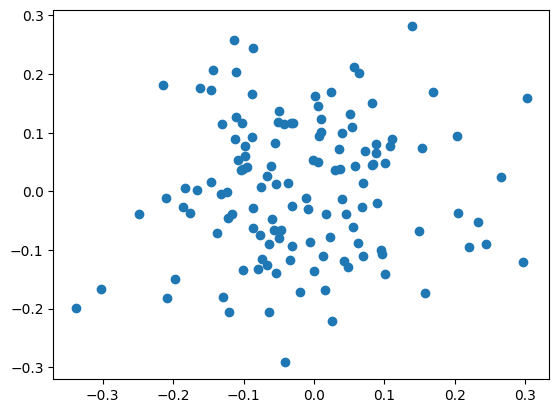


WK matrix:


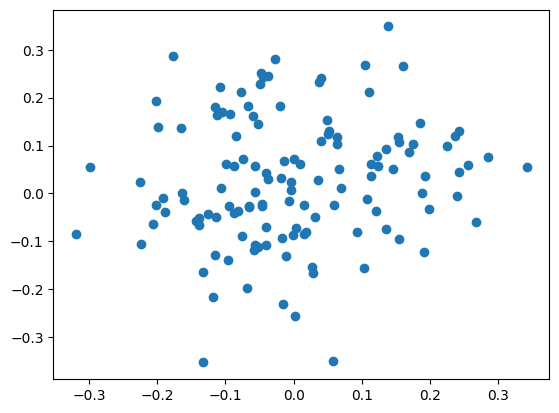


WV matrix:


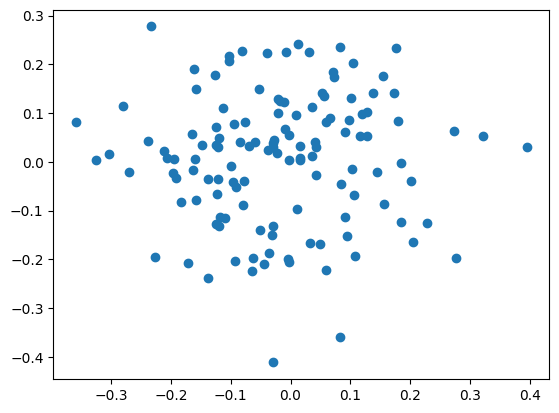

In [65]:
#Lets try to initialize the K,Q,V wieghts
import torch.nn as nn
import torch.nn.init as init
d_model = 128
input = nn.Linear(4, d_model)(input) # We need to reshape the input to be compatible for multiplication with our QKV weights
input = input.reshape(1,5,d_model)
# Our example input has a column dimension of 5, or 5 featues/tokens in the sequence: I, am, a, human, <EOS>
# This is important for the linear layers


# Set dimensions of the weights
W_Q = nn.Linear(d_model, d_model, bias=False)
W_K = nn.Linear(d_model, d_model, bias=False)
W_V = nn.Linear(d_model, d_model, bias=False)

nn.init.kaiming_normal_(W_Q.weight)
nn.init.kaiming_normal_(W_K.weight)
nn.init.kaiming_normal_(W_V.weight)

with torch.no_grad():
    print("WQ matrix:")
    plot_tensor(W_Q.weight)
    print("\nWK matrix:")
    plot_tensor(W_K.weight)
    print("\nWV matrix:")
    plot_tensor(W_V.weight)



Q matrix:


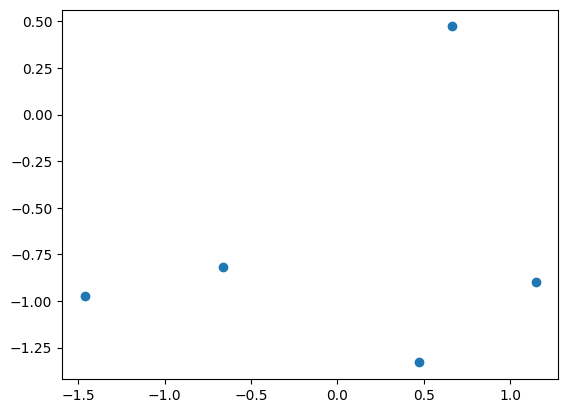


K matrix:


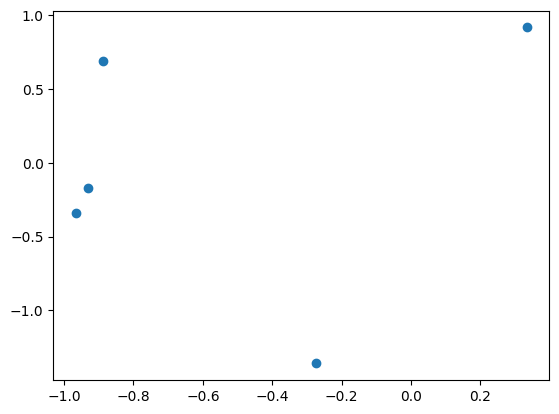


V matrix:


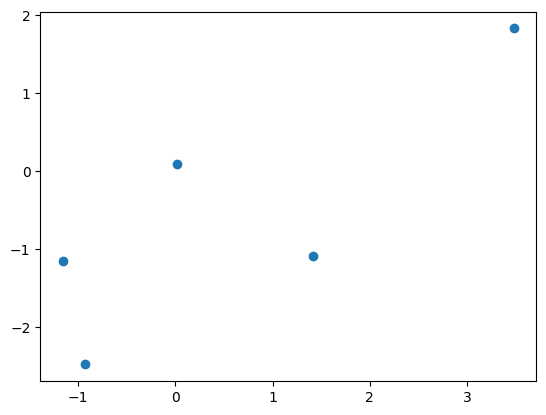

In [66]:
import math
# Lets compute Q,K,V first linear projection
with torch.no_grad():
    Q = W_Q(input)
    K = W_K(input)
    V = W_V(input)
    print("Q matrix:")
    plot_tensor(Q) # Changing print statements so I can see only the last two dimensions
    print("\nK matrix:")
    plot_tensor(K)
    print("\nV matrix:",)
    plot_tensor(V)
    

In [67]:
print(Q.shape)

torch.Size([1, 5, 128])


Scaled Dot Product:


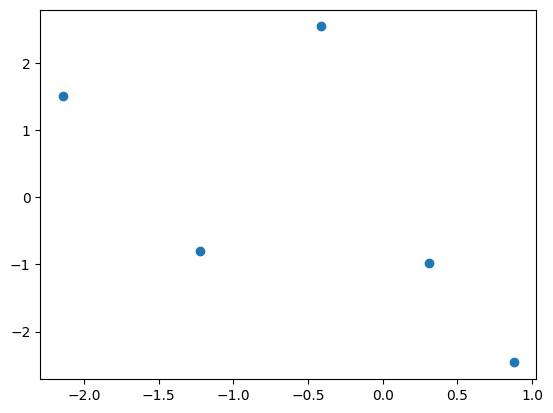

In [68]:
# Scaled dot-product    
with torch.no_grad():
    attention_weights = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_model)
    print("Scaled Dot Product:")
    plot_tensor(attention_weights)

Softmax:


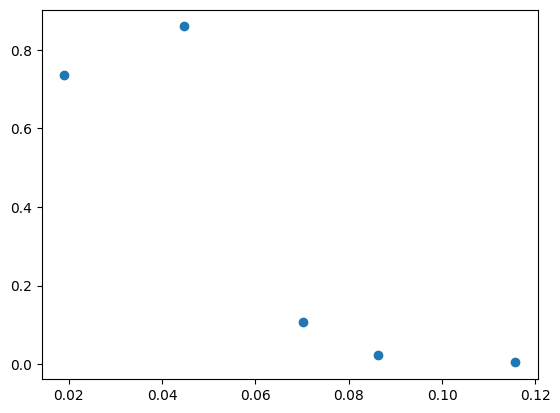

In [69]:
with torch.no_grad():
    #softmax
    attention_weights = torch.softmax(attention_weights, dim=-1)
    print("Softmax:")
    plot_tensor(attention_weights)

Output:


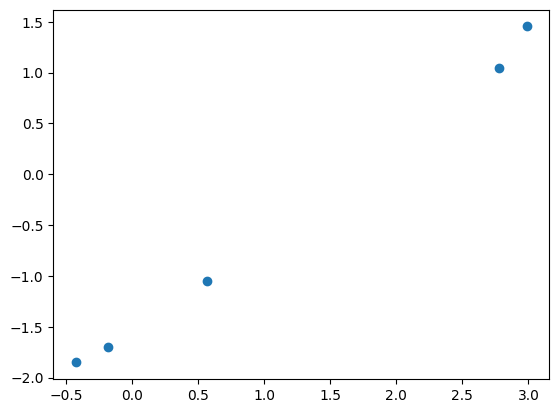

In [70]:
with torch.no_grad():
    #Last linear layer
    print("Output:")
    output = torch.matmul(attention_weights, V)
    plot_tensor(output)

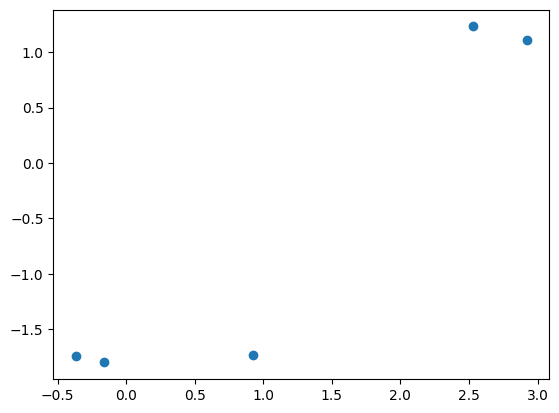

In [71]:
# Applying layer normalization to a mini batch
# Remember d_model is our embedding dimension
dropout = nn.Dropout(p=0.1)
layer_norm = nn.LayerNorm(output.size()[-1])
# We now will call the norm layer with our output
output = dropout(output)
output = layer_norm(output)
plot_tensor(output)

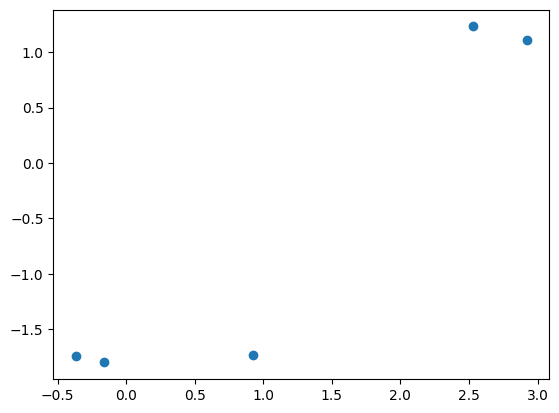

In [72]:
with torch.no_grad():
    plot_tensor(output)

In [73]:
# a class for making multihead attetnion sublayer easier
import torch
import torch.nn as nn
import math

class MultiheadAttentionSublayer(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.linears = nn.ModuleList([nn.Linear(embed_dim, embed_dim) for _ in range(3)])
        self.layer_norm = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, x, attn_mask):
        q, k, v = [l(x) for l in self.linears]
        x, attn = self.attention(q, k, v, attn_mask)
        x = x + self.dropout(x)
        x = self.layer_norm(x)
        return x, attn

    def attention(self, q, k, v, attn_mask):
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(k.size(-1))
        if attn_mask is not None:
            scores = scores.masked_fill(attn_mask, -1e9)
        attn = torch.softmax(scores, dim=-1)
        x = torch.matmul(attn, v)
        return x, attn
        
model = MultiheadAttentionSublayer(d_model, 6)
attn_mask = None
attention_weights, weighted_output = model(input, attn_mask) # Compute the output of the forward method
print(weighted_output.shape) # Print the output tensor to verify it
print(input.shape)
print(d_model)


torch.Size([1, 5, 5])
torch.Size([1, 5, 128])
128


In [74]:
# Lets do the last step in the encoder - feed forward
import torch.nn as nn

# Define the feedforward layer
feedforward = nn.Sequential(
    nn.Linear(output.size()[-1], 16),
    nn.ReLU(),
    nn.Linear(16, d_model)
)

# Pass the normalized tensor through the feedforward layer
encoder_output = feedforward(output)

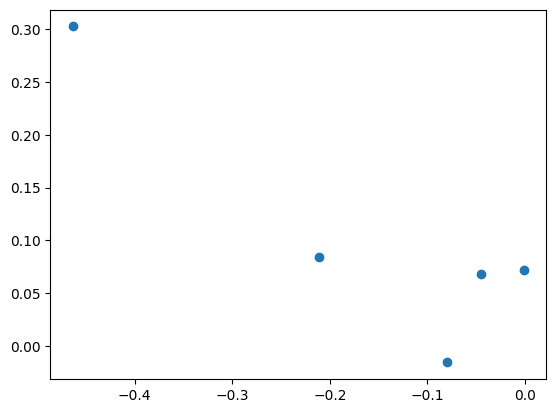

In [75]:
with torch.no_grad():
    plot_tensor(encoder_output)

In [76]:
# Apply another norm layer to finish the encoder!!!!
# Applying layer normalization to a mini batch
# Remember d_model is our embedding dimension
dropout = nn.Dropout(p=0.1)
layer_norm = nn.LayerNorm(encoder_output.size()[-1])
# We now will call the norm layer with our output
encoder_output = dropout(encoder_output)
encoder_output = layer_norm(encoder_output)
print(encoder_output)

tensor([[[-1.2758e+00,  5.8222e-01, -1.6155e+00, -2.0572e+00,  1.5746e+00,
          -8.2548e-01, -7.6016e-01, -8.0285e-01,  5.4076e-02, -9.9537e-01,
          -8.3200e-01,  2.2807e+00, -6.4951e-01, -3.7559e-02,  2.6845e-01,
          -1.1748e+00,  5.9450e-01, -9.7791e-01,  5.4137e-01, -3.7114e-01,
           5.4076e-02,  1.5524e+00,  3.9905e-01,  5.4076e-02,  6.4040e-01,
           1.5927e+00, -8.3151e-01, -6.0956e-01, -1.0604e+00,  5.5038e-01,
          -1.6660e+00,  4.9337e-01,  5.4076e-02,  1.5665e+00,  5.4076e-02,
          -1.2989e+00,  5.4076e-02,  2.5343e+00, -1.1059e+00, -6.8526e-01,
          -3.1394e-01,  1.8228e-01, -3.6675e-01,  1.1149e+00,  1.2506e-02,
          -1.6500e+00,  1.3053e+00,  2.5051e+00,  3.1908e-01,  5.4076e-02,
           3.5148e-01, -4.0098e-02,  4.8387e-01,  1.2291e+00,  7.6162e-01,
          -5.0177e-01, -1.2484e+00, -1.2363e+00,  1.2402e+00,  2.2980e-01,
           7.2953e-01,  5.4076e-02,  4.0796e-01,  3.8155e-01, -2.1328e-01,
          -1.2107e+00, -5

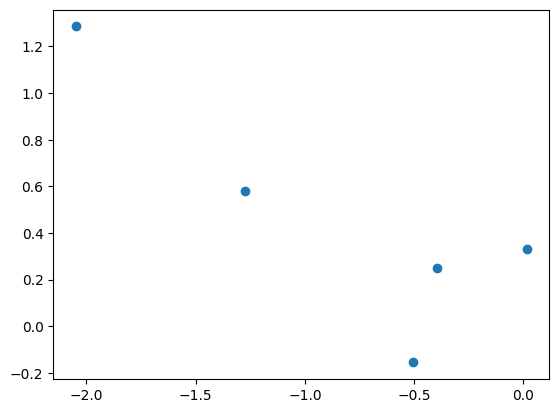

torch.Size([1, 5, 128])


In [77]:
with torch.no_grad():
    plot_tensor(encoder_output)
    print(encoder_output.shape)

In [78]:
#Keep this for the decoder implementation

def generate_attn_mask(input_seq, padding_idx):
    attn_mask = (input_seq != padding_idx).unsqueeze(1).unsqueeze(2)
    attn_mask = attn_mask.to(torch.float32).masked_fill(attn_mask == 0, float('-inf'))
    return attn_mask

If a tensor requires grads, use this method,
# Convert the tensor to a numpy array
tensor_numpy = tensor.cpu().numpy()

# Create a DataFrame using the numpy array
df = pd.DataFrame(tensor_numpy)

# Display the DataFrame
print(df)

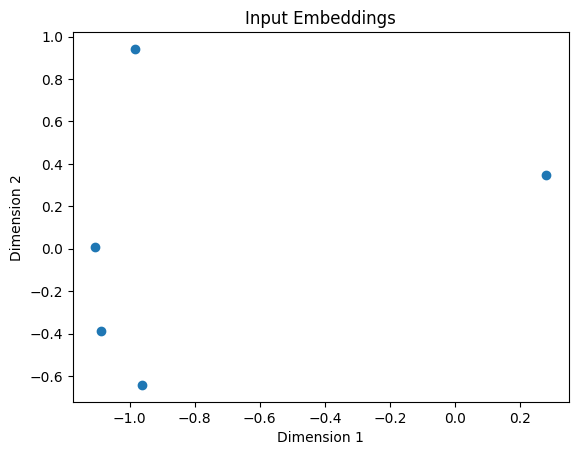

In [79]:
import matplotlib.pyplot as plt
with torch.no_grad():
    # extract the embeddings from the input tensor
    embeddings = input[0, :, :2]

    # create a scatter plot of the first two dimensions of the embeddings
    plt.scatter(embeddings[:, 0], embeddings[:, 1])

    # add a title and axis labels
    plt.title('Input Embeddings')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')

    # show the plot
    plt.show()


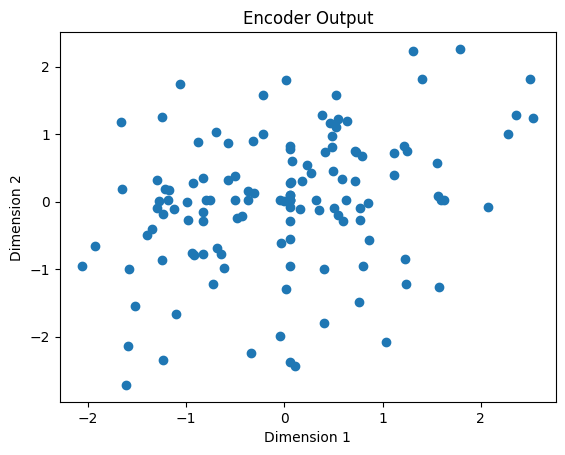

In [80]:
import matplotlib.pyplot as plt
import numpy as np

output = encoder_output.transpose(1,2)
output = output.detach().numpy()
output = output.squeeze(0)
plt.scatter(output[:, 0], output[:, 1])

# add a title and axis labels
plt.title('Encoder Output')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

# show the plot
plt.show()